## EEG - Deep Learning

### DATASET LOADING
The data is sourced from the Mental Arithmetic Tasks Dataset available at PhysioNet (https://physionet.org/content/eegmat/1.0.0/).

In [1]:
!wget https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip

--2024-07-04 19:06:29--  https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183634285 (175M) [application/zip]
Saving to: 'eeg-during-mental-arithmetic-tasks-1.0.0.zip'

eeg-during-mental-a 100%[===================>] 175.13M   391KB/s    in 6m 4s   

2024-07-04 19:12:34 (492 KB/s) - 'eeg-during-mental-arithmetic-tasks-1.0.0.zip' saved [183634285/183634285]



In [2]:
#unzipping the zip file
!unzip eeg-during-mental-arithmetic-tasks-1.0.0.zip

Archive:  eeg-during-mental-arithmetic-tasks-1.0.0.zip
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject24_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/SHA256SUMS.txt  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject17_1.edf  
 extractin

### IMPORTING LIBRARIES

In [3]:
!pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 65.9 MB/s eta 0:00:00:00:01


In [66]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.signal import welch
import seaborn as sns
import pyedflib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy import interpolate
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [67]:
#Checking device availibility(cuda/cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### DATA EXPLORATION

In [71]:
subject_data = pd.read_csv("eeg-during-mental-arithmetic-tasks-1.0.0/subject-info.csv")
subject_data.head()

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0


In [74]:
f = open("eeg-during-mental-arithmetic-tasks-1.0.0/RECORDS", "r")
print(f.read()[:200])

Subject00_1.edf
Subject00_2.edf
Subject01_1.edf
Subject01_2.edf
Subject02_1.edf
Subject02_2.edf
Subject03_1.edf
Subject03_2.edf
Subject04_1.edf
Subject04_2.edf
Subject05_1.edf
Subject05_2.edf
Subject0


In [6]:
#Choosing a random .edf file to base our analysis on
#Loading the '.edf' file for subject 14 during rest and during arithmetic calculation.

file_path1 = 'eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_1.edf'
file_path2 = 'eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_2.edf'

raw1 = mne.io.read_raw_edf(file_path1, preload=True)
raw2 = mne.io.read_raw_edf(file_path2, preload=True)

Extracting EDF parameters from /kaggle/working/eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /kaggle/working/eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


In [7]:
raw1.info

Measurement date,"January 01, 2010 00:00:00 GMT"
Experimenter,Unknown
Participant,6
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


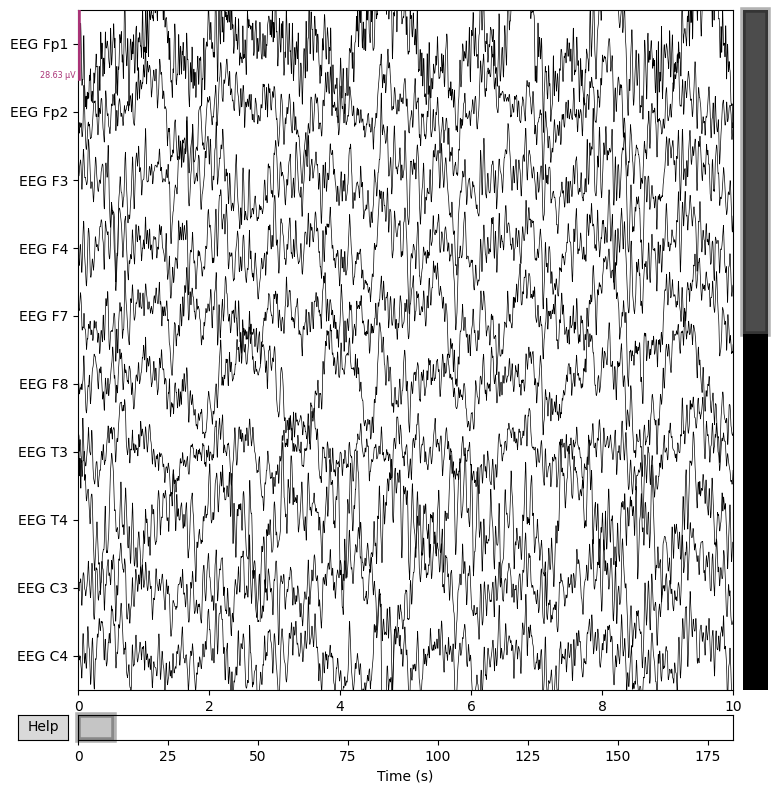

In [89]:
#Plotting the first 10 channels of the signal.
raw1.plot(n_channels=10, scalings='auto', block=True)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_34/795282388.py:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw1.plot_psd(fmin=1., fmax=120., show=True)
/tmp/ipykernel_34/795282388.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw1.plot_psd(fmin=1., fmax=120., show=True)


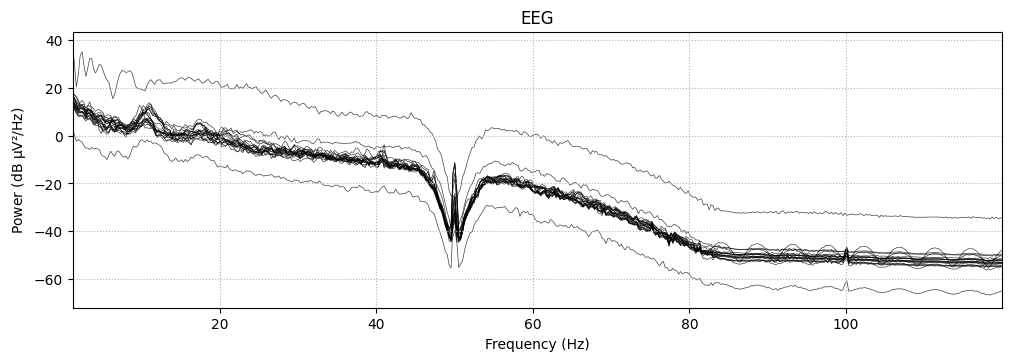

In [85]:
#Plotting the psd for frequencies between 1 and 100 hz.
#Before arithmetic operation.
plt.close('all')
fig = raw1.plot_psd(fmin=1., fmax=120., show=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_34/1923049311.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw2.plot_psd(fmin=1., fmax=120., show=True)
/tmp/ipykernel_34/1923049311.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw2.plot_psd(fmin=1., fmax=120., show=True)


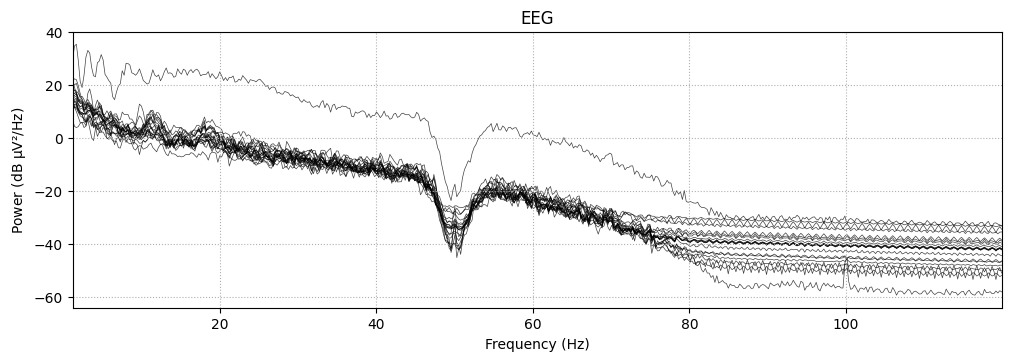

In [87]:
#During arithmetic operation.
plt.close('all')
fig = raw2.plot_psd(fmin=1., fmax=120., show=True)

### PREPARING A DATAFRAME FOR FURTHER USE

In [88]:
#Loading Signals in list along with their file names for labels
signals = []
file_name = []

directory_path = "eeg-during-mental-arithmetic-tasks-1.0.0"   
for file in os.listdir(directory_path):
    if file.endswith(".edf"):   # .edf is extension for eeg file
        file_name.append(file)
        file_path = os.path.join(directory_path, file)
        f = pyedflib.EdfReader(file_path)
        num_signals = f.signals_in_file 
        signal = []
        for i in range(num_signals): #Iteraing through number of channels
            signal.append(f.readSignal(i))
        signals.append(np.array(signal))
        f.close()

In [12]:
#Dataframe preparation 
df = pd.DataFrame({
    'Signal': signals,
    'Name': file_name,
})
df.sort_values(by='Name', ascending=True, inplace=True) 
df = df.reset_index().drop(columns=['index'])
df['State'] = df['Name'].str[10:11].astype(int) #Stripping filename for state
df['Person'] = df['Name'].str[7:9].astype(int) #Stripping filename for each person number
df = df.drop(columns = ['Name'])
df = pd.get_dummies(df , columns = ['State'] , drop_first = True) #Getting dummy values for classification
df.head()

,Signal,Person,State_2
0,"[[-3.647937628137637, -4.2364816766613265, -4....",0,False
1,"[[4.476049125658048, 1.2080211680781288, -2.54...",0,True
2,"[[-6.347912214236662, -5.884709218585484, -5.1...",1,False
3,"[[13.990337165484092, 12.876662806134126, 11.8...",1,True
4,"[[-1.4898168015564115, -3.518470470435636, -5....",2,False


In [13]:
def calculate_band_powers(eeg_data):
    fs = 500 #Sampling rate
    bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}
    
    band_powers = {band: [] for band in bands}
    
    for channel in eeg_data: #Iterating through each channel
        f, psd = welch(channel, fs, nperseg=1024) #Returns the power and corresponding frequncy for each channel
        for band, (low, high) in bands.items():
            band_power = np.trapz(psd[(f >= low) & (f <= high)], f[(f >= low) & (f <= high)]) #Adding the power in each band
            band_powers[band].append(band_power) 
            total_power = {band: np.sum(powers) for band, powers in band_powers.items()}

    return total_power #Returning dictionary containing power in each band

In [14]:
#Initializing dataframe for rest and task that will power value for each person at that band
df_rest = pd.DataFrame(columns=['Delta','Theta','Alpha','Beta','Gamma'])
df_task = pd.DataFrame(columns=['Delta','Theta','Alpha','Beta','Gamma'])

In [16]:
for index, row in df.iterrows():
    if row['State_2'] == False: #During rest
        x = calculate_band_powers(row['Signal'])
        x = pd.DataFrame([x])
        df_rest = pd.concat([df_rest, x], ignore_index=True)
    
    elif row['State_2'] == True: #During activity
        x = calculate_band_powers(row['Signal'])
        x = pd.DataFrame([x])
        df_task = pd.concat([df_task, x], ignore_index=True)

/tmp/ipykernel_34/2579019815.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_rest = pd.concat([df_rest, x], ignore_index=True)
/tmp/ipykernel_34/2579019815.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_task = pd.concat([df_task, x], ignore_index=True)


In [17]:
#Below two dataframes contain power in each band for a person in rest and while arithmetic calculation for ease of plotting and comparision.
df_rest.head()

,Delta,Theta,Alpha,Beta,Gamma
0,450.191805,244.108001,905.359753,492.597515,28.485613
1,348.563156,207.759343,287.572089,370.574169,55.392396
2,600.656098,210.918975,543.541052,511.926819,110.689917
3,349.694534,331.827997,1017.884748,255.635971,24.078535
4,1001.094762,503.771688,729.250619,554.973260,43.317515


In [18]:
df_task.head()

,Delta,Theta,Alpha,Beta,Gamma
0,571.896743,234.168000,804.732005,499.094898,39.493581
1,1113.988845,390.479589,267.519252,368.105158,52.684654
2,407.268558,143.862281,380.381411,505.572866,114.856310
3,266.956729,180.787108,304.425754,139.136489,15.372531
4,687.415601,458.596439,400.506125,505.875213,24.036411


Each value on X axis corresponds to a person, for a particular frequency band , blue is for power during rest and red for power during a task.

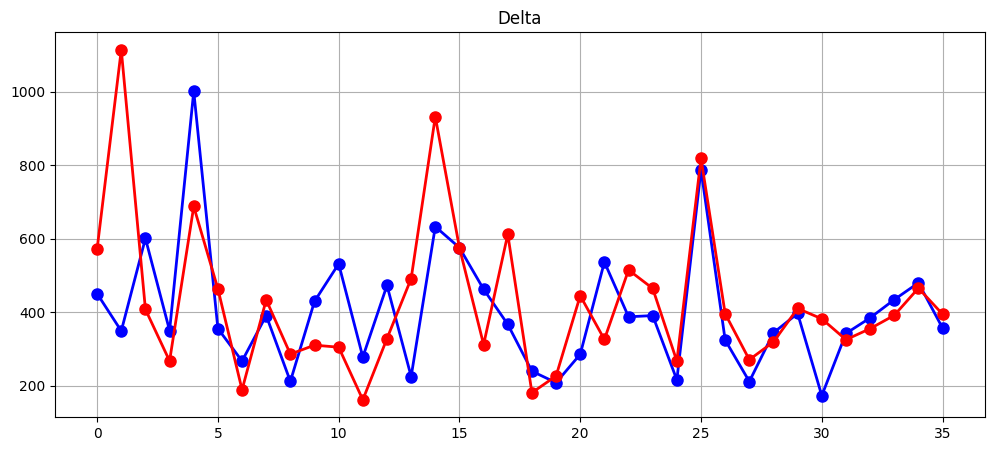

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Delta'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Delta'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Delta')
plt.show()

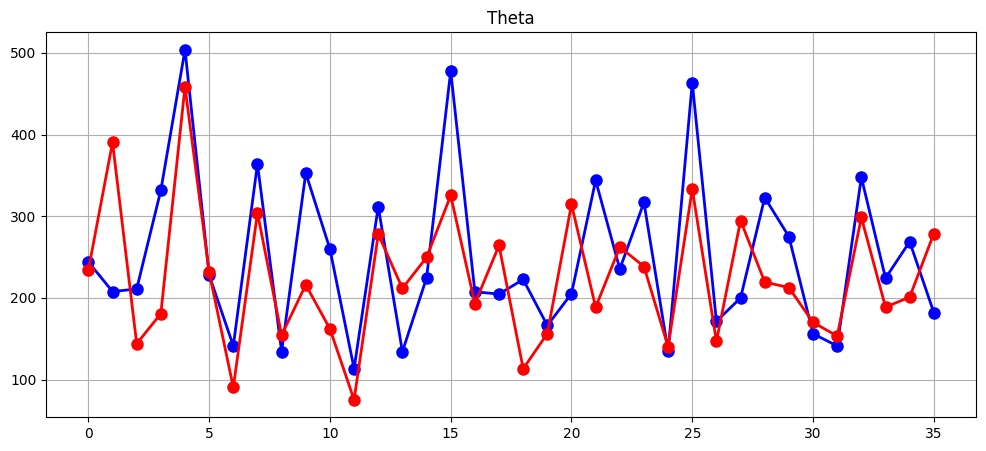

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Theta'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Theta'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Theta')
plt.show()

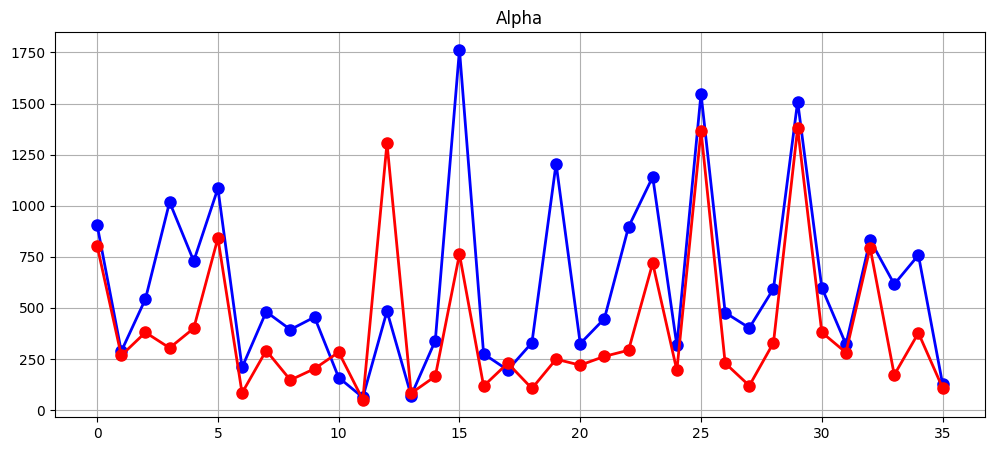

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Alpha'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Alpha'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Alpha')
plt.show()

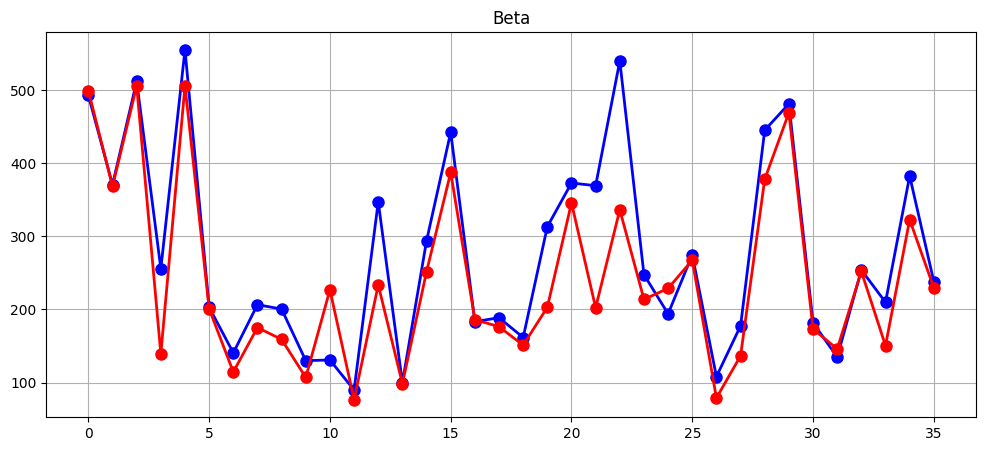

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Beta'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Beta'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Beta')
plt.show()

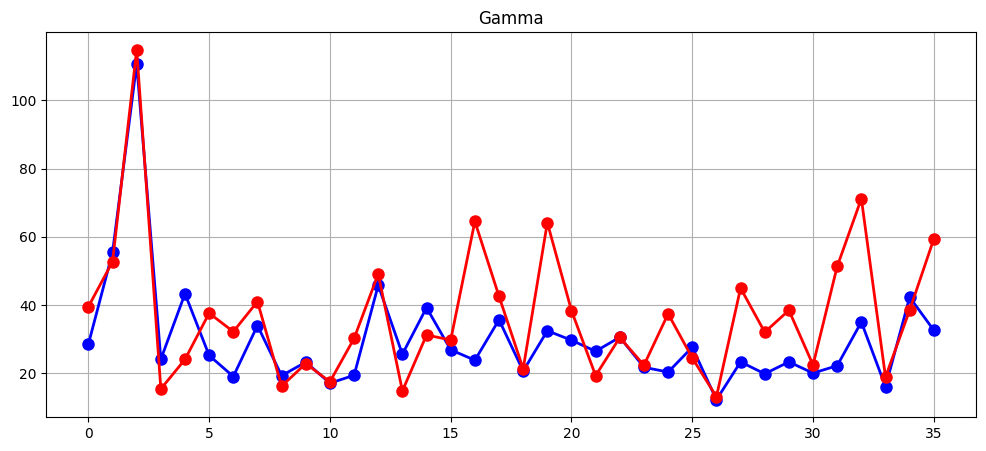

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Gamma'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Gamma'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Gamma')
plt.show()

#### PSD Summary
Delta - Largely remains same in both irrespective of rest or task.<br>
Theta - Largely follows the same trajectory with slightly more power during task.<br>
Alpha - It can be clearly seen that more power is emitted during arithmetic task.<br>
Beta - A trend similar to alpha is observed.<br>
Gamma - Remains largely the same.

### DATA PREPARATION FOR MODEL TRAINING

In [26]:
#The timestamp in each signal is variable so getting the average timestamp so that we can truncate or pad data accordingly
avg = df['Signal'].apply(lambda x: x.shape[1]).mean()
avg

60250.0

In [27]:
#Size before operation
print(f"Shape of each each tensor in state 1 {df['Signal'][0].shape}")
print(f"Shape of each each tensor in state 2 {df['Signal'][1].shape}")

Shape of each each tensor in state 1 (21, 91000)
Shape of each each tensor in state 2 (21, 31000)


In [28]:
#Making timestamp to common length of 60250
#Padding and truncating the sequences to common length of 60250

def pad_or_truncate(signal):
    target_length = 60250
    if signal.shape[1] > target_length:
        return signal[:, :target_length]  #Truncating
    else:
        pad_width = target_length - signal.shape[1]
        return np.pad(signal, ((0, 0), (0, pad_width)), mode='constant')  #Padding

df['Signal']=df['Signal'].apply(pad_or_truncate)
print(f"Shape of each each tensor in state 1 {df['Signal'][0].shape}")
print(f"Shape of each each tensor in state 2 {df['Signal'][1].shape}")

Shape of each each tensor in state 1 (21, 60250)
Shape of each each tensor in state 2 (21, 60250)


In [29]:
#Spliting the data into test and train
x_train, x_test, y_train, y_test = train_test_split(
    df['Signal'], df['State_2'], test_size=0.20, random_state=42,stratify = df['State_2'])
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [30]:
#Defining a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, transform=None):
        self.X_train = X_train
        self.y_train = y_train
        self.transform = transform

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        x = self.X_train[idx]
        y = self.y_train[idx]
        
        if self.transform:
            x = self.transform(x)

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(y, dtype=torch.float32)

        return x.to(device), y.to(device)

### DEFINING MODEL CLASS EGGNet

In [31]:
#Defining the model class
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, (1, 1000), padding=0, stride =(3,1)) #Temporal filter
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        
        self.conv2 = nn.Conv2d(16, 4, (2, 1000)) #Spatial Filter
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        
        self.conv3 = nn.Conv2d(4, 4, (8, 500)) #Spatial Filter
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        self.fc1 = nn.Linear(14072, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.padding1(x)
        
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.pooling2(x)
        x = self.padding2(x)
        
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pooling3(x)
        x = x.view(x.size(0), -1)  #Flattening data
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))

        return x

In [32]:
#Testing
random = torch.randn(1,1,21,60250)
model = EEGNet()
model(random)

tensor([[0.5169]], grad_fn=<SigmoidBackward0>)

### INITIALIZING MODEL PARAMETERS AND DATALOADER

In [33]:
dataset = CustomDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [34]:
dataset[0][0].shape

torch.Size([1, 21, 60250])

In [43]:
net = EEGNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

### MODEL TRAINING

In [44]:
num_epochs = 5
loss_e = []

for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for x, y in progress_bar:
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))
        
        del x, y, outputs, loss
        gc.collect()
        torch.cuda.empty_cache()
    
    avg_epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    loss_e.append(avg_epoch_loss)

Epoch 1/5: 100%|██████████| 4/4 [01:13<00:00, 18.37s/it, loss=0.357]


Epoch [1/5], Loss: 0.3575


Epoch 2/5: 100%|██████████| 4/4 [01:13<00:00, 18.36s/it, loss=0.066] 


Epoch [2/5], Loss: 0.0660


Epoch 3/5: 100%|██████████| 4/4 [01:13<00:00, 18.37s/it, loss=0.0242]


Epoch [3/5], Loss: 0.0242


Epoch 4/5: 100%|██████████| 4/4 [01:13<00:00, 18.37s/it, loss=0.00424]


Epoch [4/5], Loss: 0.0042


Epoch 5/5: 100%|██████████| 4/4 [01:13<00:00, 18.37s/it, loss=0.00291]

Epoch [5/5], Loss: 0.0029


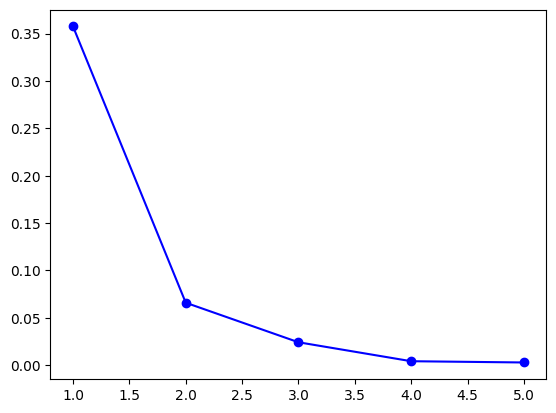

In [45]:
epochs =np.array(range(0, 5))+1
plt.plot(epochs, loss_e, marker='o', linestyle='-', color='b')
plt.show()

### MODEL EVALUATION

In [46]:
def evaluate_model(model, dataloader):
    model.eval()  
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():  #Freezing weights
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float()  
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)
    
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [47]:
#Test data
test_dataset = CustomDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
evaluate_model(net,test_loader)

Accuracy: 0.7333
Precision: 1.0000
Recall: 0.4286
F1 Score: 0.6000


In [48]:
#Train data
evaluate_model(net,dataloader)

Accuracy: 0.8596
Precision: 1.0000
Recall: 0.7241
F1 Score: 0.8400


In [49]:
#Entire data
x = df['Signal']
y = df['State_2']
t_dataset = CustomDataset(x, y)
t_loader = DataLoader(t_dataset, batch_size=4, shuffle=False)
evaluate_model(net,t_loader)

Accuracy: 0.8333
Precision: 1.0000
Recall: 0.6667
F1 Score: 0.8000


### DEFINING MODEL CLASS TSCeption Net

In [50]:
#Defining the model class
class Tsception(nn.Module):
    def __init__(self):
        super(Tsception, self).__init__()

        self.temporal_conv1 = nn.Conv2d(1, 16, (1, 8), padding=(0, 4),stride=(1,5))
        self.temporal_conv2 = nn.Conv2d(1, 16, (1, 16), padding=(0, 8),stride=(1,5))
        self.spatial_conv1 = nn.Conv2d(32, 64, (21, 1),stride = (1,5))

        self.fc1 = nn.Linear(154304 , 1000)
        self.fc2 = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = torch.relu(self.temporal_conv1(x))
#         print(x1.shape)
        x2 = torch.relu(self.temporal_conv2(x))
#         print(x2.shape)

        x = torch.cat((x1, x2), dim=1)  #Concatining the two temporal operation 
#         print(x.shape)

        x = torch.relu(self.spatial_conv1(x)) #Appling spatial operation
#         print(x.shape)

        x = x.view(x.size(0), -1)  #Flattening it to put into fully connected layer
#         print(x.shape)

        x = torch.relu(self.fc1(x))
#         print(x.shape)

        x = self.fc2(x)
#         print(x.shape)

        x = self.sigmoid(x)
        
        return x

In [51]:
#Test run
x = torch.randn(1,1,21,60250)
model_ = Tsception()
model_(x)

tensor([[0.5096]], grad_fn=<SigmoidBackward0>)

### INITIALZING MODEL PARAMETERS AND DATALOADER

In [52]:
#Initializing dataset class and dataloader
dataset_ = CustomDataset(x_train, y_train)
dataloader_ = DataLoader(dataset_, batch_size=16, shuffle=False)

In [60]:
#Initializing model and model parameters
net = Tsception().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

### TRAINING

In [61]:
num_epochs = 2
loss_e = []

for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(dataloader_, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for x, y in progress_bar:
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))
        
        del x, y, outputs, loss
        gc.collect()
        torch.cuda.empty_cache()
    
    avg_epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    loss_e.append(avg_epoch_loss)

Epoch 1/2: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, loss=0.181]


Epoch [1/2], Loss: 0.1813


Epoch 2/2: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s, loss=0.0769]

Epoch [2/2], Loss: 0.0769


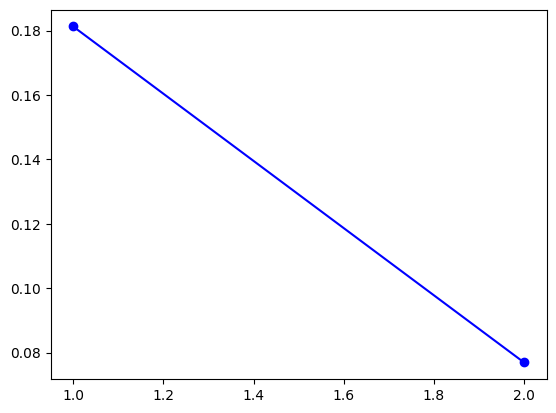

In [69]:
epochs =np.array(range(0, 2))+1
plt.plot(epochs, loss_e, marker='o', linestyle='-', color='b')
plt.show()

### MODEL EVALUATION

In [62]:
def evaluate_model(model, dataloader):
    model.eval()  
    all_targets = []
    all_predictions = []
    
    with torch.no_grad(): 
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float()  
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)
    
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

In [63]:
#Test data
test_dataset = CustomDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
evaluate_model(net,test_loader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [64]:
#Train data
evaluate_model(net,dataloader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [65]:
#Entire data
x = df['Signal']
y = df['State_2']
t_dataset = CustomDataset(x, y)
t_loader = DataLoader(t_dataset, batch_size=4, shuffle=False)
evaluate_model(net,t_loader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
